In [42]:
from ultralytics import YOLO
import numpy as np
import pandas as pd
import json
import os 
import shutil
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy
import warnings
warnings.filterwarnings("ignore")

In [23]:
#将预测结果转换为json格式
def predict2json(predict_result,output_json):
    rotation_type = output_json['shapes'][0]
    point_type = output_json['shapes'][1]
    #读取预测信息-------------------------------------------------------------------------
    obb_data = predict_result.obb
    #类别
    classes_change = {0:'comma',1:'spiral'}
    classes = [classes_change[i] for i in obb_data.cls.cpu().numpy()]
    #direction
    #obb得到角度是短边顺时针转到x轴正轴的角度（弧度值）
    #xanylabel的角度似乎是短边顺时针转到y轴正轴的角度（弧度值）
    angles = np.radians(obb_data.xywhr.cpu().numpy()[:,-1]/np.pi*180-90)
    angles = np.where(angles<0,angles+np.pi*2,angles).tolist()
    #旋转框
    boxes = obb_data.xyxyxyxy.cpu().numpy()
    #关键点
    points = predict_result.keypoints.xy.cpu().numpy()
    #image_shape
    orig_shape = obb_data.orig_shape
    filename = os.path.basename(predict_result.path)
    #写入json信息---------------------------------------------------------------------------------------------
    output_json['imagePath'] = filename
    output_json['imageHeight'],output_json['imageWidth'] = orig_shape[1],orig_shape[0]
    shapes = []
    #写入边框信息
    for j in range(len(classes)):
        #旋转框
        temp_rotation = rotation_type.copy()
        temp_rotation['direction'] = angles[j]
        temp_rotation['points'] = boxes[j].tolist()
        temp_rotation['label'] = classes[j]
        temp_rotation['group_id'] = j
        shapes.append(temp_rotation)
        #关键点
        temp_point = point_type.copy()
        temp_point['label'] = classes[j]+'_center'
        temp_point['points'] = [points[j].tolist()]
        temp_point['group_id'] = j
        shapes.append(temp_point)
    output_json['shapes'] = shapes
    return output_json
#将json格式转换为yolo格式
def json_to_yolo_obb_pose(load_dict):
    class_name = {'comma':0,'spiral':1}
    #由于都是正方形所有只需要读图片高度即可
    height = load_dict['imageHeight']
    #标注的框
    shapes = load_dict['shapes']
    boxes,points = [],[]
    box_column  = ['group_id','label','x1','y1','x2','y2','x3','y3','x4','y4']
    point_column = ['group_id','x0','y0','is_visible']
    for idx,temp in enumerate(shapes):
        if temp['shape_type']=='point':
            points.append([temp['group_id']]+np.round(np.array(temp['points']).flatten()/height,3).tolist()+[2])
        else: 
            boxes.append([temp['group_id'],temp['label']]+np.round(np.array(temp['points']).flatten()/height,3).tolist())
    box_df = pd.DataFrame(boxes,columns=box_column).set_index('group_id')
    point_df = pd.DataFrame(points,columns=point_column).set_index('group_id')
    #检验标签的group_id
    flag = np.array_equal(np.sort(box_df.index.values),np.sort(point_df.index.values))
    if np.sum(~np.isin(box_df.label,['comma','spiral']))!=0:
        flag=False
    if flag:
        #当两者没有共同group_id时会为空
        result = pd.DataFrame(boxes,columns=box_column).set_index('group_id').join(pd.DataFrame(points,columns=point_column).set_index('group_id'),how='inner')
    else:
        raise ValueError('%s:error'%load_dict['imagePath'])
    result = result.replace(class_name)
    result = result.infer_objects(copy=False)
    result['filename'] = load_dict['imagePath']
    return result

In [28]:
#读取一个demo_json作转X_anylabeling Json文件的样例
with open(r"D:\Desktop\pycode\PLs_identity\IMPMCT\example_data\X_anylabeling_ex.json",'r', encoding='UTF-8') as f:
    demo_json = json.load(f)
demo_json

{'version': '2.4.4',
 'flags': {},
 'shapes': [{'kie_linking': [],
   'direction': 5.086040019989014,
   'label': 'comma',
   'score': None,
   'points': [[604.2460935, 589.125],
    [681.4517107332919, 392.2067729227882],
    [318.2195737246093, 249.79455566406244],
    [241.01395649131737, 446.7127827412743]],
   'group_id': 0,
   'description': '',
   'difficult': False,
   'shape_type': 'rotation',
   'flags': {},
   'attributes': {}},
  {'kie_linking': [],
   'label': 'comma_center',
   'score': None,
   'points': [[401.74609350000003, 401.00000000000006]],
   'group_id': 0,
   'description': '',
   'difficult': False,
   'shape_type': 'point',
   'flags': {},
   'attributes': {}}],
 'imagePath': '1-1.png',
 'imageData': None,
 'imageHeight': 801,
 'imageWidth': 801,
 'text': '',
 'description': ''}

In [3]:
ERA5_matched = pd.read_excel(r'D:\Desktop\pycode\PLs_identity\IMPMCT\example_data\matched_ERA5_tracks_2008_11.xlsx').drop(columns=['old_lon','old_lat'])#.drop(columns=['Unnamed: 0'])

In [4]:
model = YOLO(r"D:\Desktop\final_dataset\yolo_dataset\models\obb_pose\train3\weights\best.pt")

D:\YOLO\ultralytics-obb_segment-main\ultralytics\nn\tasks.py:776: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location="cpu")



image 1/1 D:\Desktop\pycode\PLs_identity\IMPMCT\example_data\vci_examples\path617_6728.png: 960x960 119.0ms
Speed: 5.7ms preprocess, 119.0ms inference, 4.0ms postprocess per image at shape (1, 3, 960, 960)


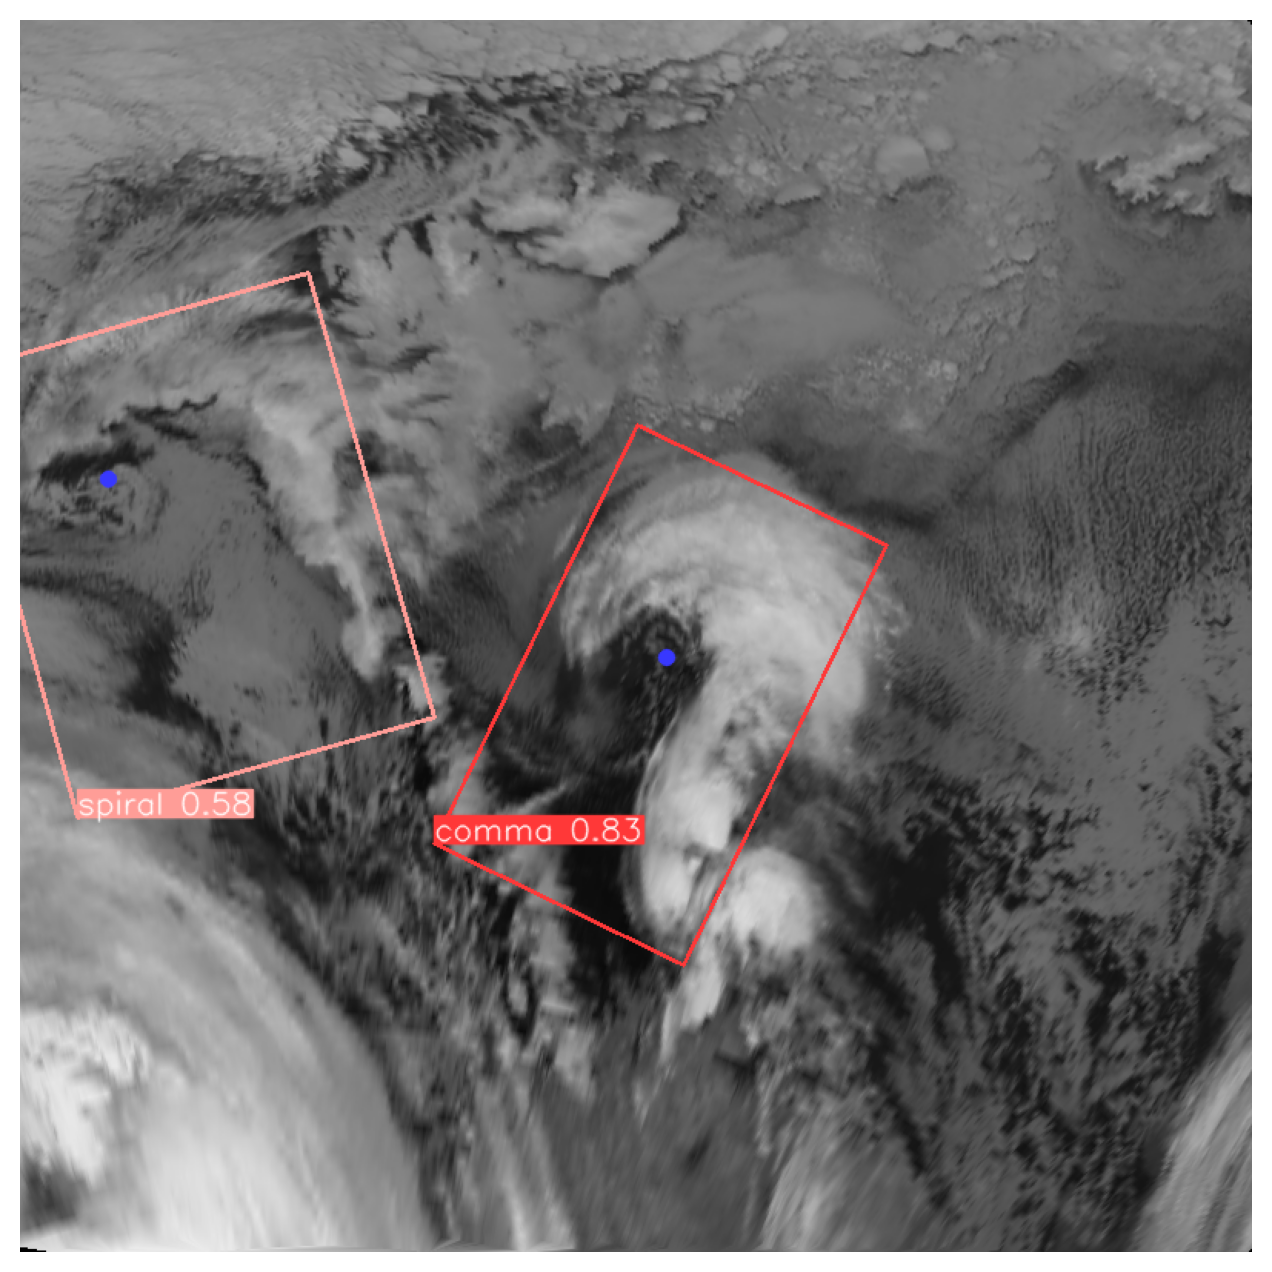

C:\Users\84648\AppData\Local\Temp\ipykernel_12060\1532543670.py:69: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result.replace(class_name)


,label,x1,y1,x2,y2,x3,y3,x4,y4,x0,y0,is_visible,filename
group_id,,,,,,,,,,,,,
0,0,0.337,0.669,0.538,0.767,0.703,0.427,0.502,0.329,0.525,0.518,2,path617_6728.png
1,1,0.047,0.647,0.336,0.566,0.234,0.205,-0.055,0.287,0.072,0.372,2,path617_6728.png


In [25]:
#stream=True:生成式预测，避免超内存
result = model.predict(source=r"D:\Desktop\pycode\PLs_identity\IMPMCT\example_data\vci_examples\path617_6728.png",device=0)[0]
fig,ax = plt.subplots(1,1,figsize=(8,8),dpi=200)
plt.imshow(result.plot()[:, :, ::-1])  # result.plot() 返回的是 BGR 格式的图片，需要转换为 RGB 格式
plt.axis('off')  # 关闭坐标轴
plt.show()
result_json = predict2json(result,demo_json)
#转为Yolo格式,实际上先转为json后还需要进行人工的微调,这里忽略了
json_to_yolo_obb_pose(result_json)

推理结果存储

In [54]:
cyclone_predict = []
results = model.predict(source=r'D:\Desktop\pycode\PLs_identity\IMPMCT\example_data\vci_examples',device=0,stream=True,conf=0.3)
for result in results:
     result_json = predict2json(result,copy.deepcopy(demo_json))
     #转为Yolo格式,实际上先转为json后还需要进行人工的微调,这里忽略了
     cyclone_predict.append(json_to_yolo_obb_pose(result_json))
cloud_infos = pd.merge(pd.concat(cyclone_predict,axis=0),ERA5_matched,how='left',on='filename')
cloud_infos


image 1/158 D:\Desktop\pycode\PLs_identity\IMPMCT\example_data\vci_examples\path617_6693.png: 960x960 78.8ms
image 2/158 D:\Desktop\pycode\PLs_identity\IMPMCT\example_data\vci_examples\path617_6694.png: 960x960 22.9ms
image 3/158 D:\Desktop\pycode\PLs_identity\IMPMCT\example_data\vci_examples\path617_6698.png: 960x960 22.8ms
image 4/158 D:\Desktop\pycode\PLs_identity\IMPMCT\example_data\vci_examples\path617_6700.png: 960x960 23.5ms
image 5/158 D:\Desktop\pycode\PLs_identity\IMPMCT\example_data\vci_examples\path617_6701.png: 960x960 22.0ms
image 6/158 D:\Desktop\pycode\PLs_identity\IMPMCT\example_data\vci_examples\path617_6702.png: 960x960 20.0ms
image 7/158 D:\Desktop\pycode\PLs_identity\IMPMCT\example_data\vci_examples\path617_6702_1.png: 960x960 20.7ms
image 8/158 D:\Desktop\pycode\PLs_identity\IMPMCT\example_data\vci_examples\path617_6703.png: 960x960 22.0ms
image 9/158 D:\Desktop\pycode\PLs_identity\IMPMCT\example_data\vci_examples\path617_6703_1.png: 960x960 21.0ms
image 10/158 D

,label,x1,y1,x2,y2,x3,y3,x4,y4,x0,...,lat,peak_value,path_index,relative,point_index,filepath,tle_name,dataset_type,satellite_name,mean_time
0,0,0.361,0.971,0.481,1.059,0.623,0.866,0.503,0.777,0.492,...,75.75,NaN,617,-999,6693,Z:\NOAA_AVHRR\NSS.GHRR.NM.D08320.S1825.E2010.B...,NOAA-17_tle.txt,GHRR,NOAA-17,2008-11-15 19:18:00
1,0,0.370,0.985,0.482,1.051,0.598,0.855,0.486,0.789,0.493,...,75.75,NaN,617,-1000,6694,Z:\NOAA_AVHRR\NSS.GHRR.M2.D08320.S1841.E2023.B...,Metop-A_tle.txt,GHRR,Metop-A,2008-11-15 20:21:00
2,0,0.400,0.798,0.629,0.849,0.714,0.470,0.485,0.419,0.546,...,75.75,NaN,617,-1000,6694,Z:\NOAA_AVHRR\NSS.GHRR.M2.D08320.S1841.E2023.B...,Metop-A_tle.txt,GHRR,Metop-A,2008-11-15 20:21:00
3,0,0.386,0.694,0.539,0.734,0.618,0.432,0.465,0.393,0.494,...,75.50,1.992283,617,3,6698,Z:\NOAA_AVHRR\NSS.GHRR.NN.D08320.S2358.E0149.B...,NOAA-18_tle.txt,GHRR,NOAA-18,2008-11-16 00:22:00
4,0,0.381,0.732,0.540,0.770,0.616,0.447,0.457,0.409,0.503,...,75.50,2.221500,617,5,6700,Z:\NOAA_AVHRR\NSS.GHRR.NN.D08321.S0143.E0336.B...,NOAA-18_tle.txt,GHRR,NOAA-18,2008-11-16 02:04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,0,0.757,0.503,0.789,0.424,0.656,0.370,0.624,0.449,0.691,...,78.25,1.957747,617,112,6807,Z:\NOAA_AVHRR\NSS.LHRR.NM.D08325.S1311.E1323.B...,NOAA-17_tle.txt,LHRR,NOAA-17,2008-11-20 13:13:00
178,1,0.380,0.485,0.493,0.500,0.509,0.386,0.396,0.370,0.439,...,78.00,1.857382,617,113,6808,Z:\NOAA_AVHRR\NSS.GHRR.NM.D08325.S1309.E1458.B...,NOAA-17_tle.txt,GHRR,NOAA-17,2008-11-20 14:03:00
179,1,0.382,0.489,0.483,0.498,0.492,0.397,0.391,0.388,0.434,...,78.00,1.857382,617,113,6808,Z:\NOAA_AVHRR\NSS.GHRR.NK.D08325.S1327.E1521.B...,NOAA-15_tle.txt,GHRR,NOAA-15,2008-11-20 14:21:00
180,1,0.380,0.470,0.479,0.472,0.480,0.372,0.382,0.371,0.429,...,77.75,1.711531,617,114,6809,Z:\NOAA_AVHRR\NSS.GHRR.NL.D08325.S1333.E1506.B...,NOAA-16_tle.txt,GHRR,NOAA-16,2008-11-20 15:05:00


去除云特征重复检测

In [44]:
def geodistance(lon1,lat1,lon2,lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2]) # 经纬度转换成弧度
    dlon=lon2-lon1
    dlat=lat2-lat1
    a=np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    distance=2*np.arcsin(np.sqrt(a))*6371*1000 # 地球平均半径，6371km
    distance=np.round(distance,3)
    return distance/1000

In [ ]:
def geo2lonlat(central_lon,central_lat,distance_x,distance_y):
    #等角投影的经纬度转换
    earth_radius = 6370856#m
    lats = distance_y/(2*np.pi*earth_radius)*360+central_lat
    lon_diff = distance_x/(2*np.pi*earth_radius*np.cos(central_lat/180*np.pi))*360
    return central_lon+lon_diff,lats

In [65]:
#唯一性
kpt_lon,kpt_lat = geo2lonlat(cloud_infos.lon,cloud_infos.lat,(cloud_infos.x0-401)*2e3,(401-cloud_infos.y0)*2e3)
cloud_infos['cloud_lon'],cloud_infos['cloud_lat'] = kpt_lon,kpt_lat
cloud_infos['dis'] = geodistance(cloud_infos.lon,cloud_infos.lat,cloud_infos.cloud_lon,cloud_infos.cloud_lat)
cloud_infos = cloud_infos.loc[cloud_infos.groupby('filename')['dis'].idxmin()].reset_index(drop=True)

In [62]:
#去重
cloud_infos['AVHRR_filename'] = cloud_infos['filepath'].apply(lambda x:os.path.basename(x))
unique_filename = np.unique(cloud_infos['AVHRR_filename'])
duplicate_indexs = []
for i in tqdm(range(len(unique_filename))):
    temp_info = cloud_infos.loc[cloud_infos.AVHRR_filename==unique_filename[i]].copy()
    all_index = temp_info.index
    while len(all_index)>1:
        central_lon,central_lat = temp_info.loc[all_index[0],['cloud_lon','cloud_lat']].values
        #小于50KM时认为是一个,cluster至少含有一个点就是自己
        distancess = geodistance(central_lon,central_lat,temp_info.loc[all_index,'cloud_lon'].values,temp_info.loc[all_index,'cloud_lat'].values)
        #cluster即多个重复检测的气旋
        cluster = temp_info.loc[all_index[distancess<=50]]
        all_index = all_index[distancess>50]
        duplicate_indexs.append(cluster.index.values)
#由于这里只选了一个轨迹因此没有重复检测的
duplicate_cloud = cloud_infos.loc[np.concatenate(duplicate_indexs)]
best_index = duplicate_cloud.loc[duplicate_cloud.groupby('filename')['dis'].idxmin()].reset_index(drop=True)
cloud_infos = cloud_infos.drop(index=duplicate_cloud.index[~np.isin(duplicate_cloud.index,best_index)])

100%|██████████| 109/109 [00:00<00:00, 2897.92it/s]


In [63]:
cloud_infos

,label,x1,y1,x2,y2,x3,y3,x4,y4,x0,...,point_index,filepath,tle_name,dataset_type,satellite_name,mean_time,cloud_lon,cloud_lat,dis,AVHRR_filename
0,0,0.361,0.971,0.481,1.059,0.623,0.866,0.503,0.777,0.492,...,6693,Z:\NOAA_AVHRR\NSS.GHRR.NM.D08320.S1825.E2010.B...,NOAA-17_tle.txt,GHRR,NOAA-17,2008-11-15 19:18:00,-13.265799,82.946498,977.019862,NSS.GHRR.NM.D08320.S1825.E2010.B3323839.GC
1,0,0.370,0.985,0.482,1.051,0.598,0.855,0.486,0.789,0.493,...,6694,Z:\NOAA_AVHRR\NSS.GHRR.M2.D08320.S1841.E2023.B...,Metop-A_tle.txt,GHRR,Metop-A,2008-11-15 20:21:00,-13.265726,82.946516,977.020308,NSS.GHRR.M2.D08320.S1841.E2023.B1077071.SV
3,0,0.386,0.694,0.539,0.734,0.618,0.432,0.465,0.393,0.494,...,6698,Z:\NOAA_AVHRR\NSS.GHRR.NN.D08320.S2358.E0149.B...,NOAA-18_tle.txt,GHRR,NOAA-18,2008-11-16 00:22:00,-12.521614,82.703621,980.483532,NSS.GHRR.NN.D08320.S2358.E0149.B1798889.GC
4,0,0.381,0.732,0.540,0.770,0.616,0.447,0.457,0.409,0.503,...,6700,Z:\NOAA_AVHRR\NSS.GHRR.NN.D08321.S0143.E0336.B...,NOAA-18_tle.txt,GHRR,NOAA-18,2008-11-16 02:04:00,-12.770967,82.703513,980.468937,NSS.GHRR.NN.D08321.S0143.E0336.B1798990.SV
6,0,0.463,0.682,0.605,0.666,0.579,0.434,0.437,0.450,0.510,...,6702,Z:\NOAA_AVHRR\NSS.GHRR.NN.D08321.S0331.E0525.B...,NOAA-18_tle.txt,GHRR,NOAA-18,2008-11-16 04:12:00,-13.270464,82.703495,980.462118,NSS.GHRR.NN.D08321.S0331.E0525.B1799091.WI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,0,0.757,0.503,0.789,0.424,0.656,0.370,0.624,0.449,0.691,...,6807,Z:\NOAA_AVHRR\NSS.LHRR.NM.D08325.S1311.E1323.B...,NOAA-17_tle.txt,LHRR,NOAA-17,2008-11-20 13:13:00,-44.357648,85.454790,940.323803,NSS.LHRR.NM.D08325.S1311.E1323.B3330606.WI
178,1,0.380,0.485,0.493,0.500,0.509,0.386,0.396,0.370,0.439,...,6808,Z:\NOAA_AVHRR\NSS.GHRR.NM.D08325.S1309.E1458.B...,NOAA-17_tle.txt,GHRR,NOAA-17,2008-11-20 14:03:00,-43.653299,85.204808,944.932641,NSS.GHRR.NM.D08325.S1309.E1458.B3330607.WI
179,1,0.382,0.489,0.483,0.498,0.492,0.397,0.391,0.388,0.434,...,6808,Z:\NOAA_AVHRR\NSS.GHRR.NK.D08325.S1327.E1521.B...,NOAA-15_tle.txt,GHRR,NOAA-15,2008-11-20 14:21:00,-43.653732,85.204610,944.922658,NSS.GHRR.NK.D08325.S1327.E1521.B5470708.GC
180,1,0.380,0.470,0.479,0.472,0.480,0.372,0.382,0.371,0.429,...,6809,Z:\NOAA_AVHRR\NSS.GHRR.NL.D08325.S1333.E1506.B...,NOAA-16_tle.txt,GHRR,NOAA-16,2008-11-20 15:05:00,-42.707418,84.955042,949.213787,NSS.GHRR.NL.D08325.S1333.E1506.B4208586.GC
